In [ ]:
pip install feedparser

In [ ]:
import feedparser
content = feedparser.parse("https://www.ft.com/?edition=international&format=rss")
print("\nTitles-------------------------\n")
for index, item in enumerate(content.entries):
  print("{0}.{1}".format(index, item["title"]))

In [3]:
import requests  # take the website source code back to you
import urllib  # some useful functions to deal with website URLs
from bs4 import BeautifulSoup as soup  # a package to parse website source code
import numpy as np  # all the numerical calculation related methods
import re  # regular expression package
import itertools  # a package to do iteration works
import pickle  # a package to save your file temporarily
import pandas as pd  # process structured data
import os

In [ ]:
sub_dir = os.getcwd() + '/DEDA_class2019_SYSU_Abstract_LDA_Crawler/'
cwd_dir = sub_dir if os.path.exists(sub_dir) else os.getcwd()  # the path you save your files
base_link = 'http://www.wiwi.hu-berlin.de/de/forschung/irtg/results/discussion-papers'  # This link can represent the domain of a series of websites
abs_link = 'https://www.wiwi.hu-berlin.de/de/forschung/irtg/results/'
# abs_folder = cwd_dir + 'Abstracts/'
# os.makedirs(abs_folder, exist_ok=True)


request_result = requests.get(base_link, headers={'Connection': 'close'})  # get source code
parsed = soup(request_result.content)  # parse source code
tr_items = parsed.find_all('tr')
info_list = []
for item in tr_items:
    link_list = item.find_all('td')
    try:
        paper_title = re.sub(pattern=r'\s+', repl=' ', string=link_list[1].text.strip())
        author = link_list[2].text
        date_of_issue = link_list[3].text
        abstract_link = link_list[5].find('a')['href']
        info_list.append([paper_title, author, date_of_issue, abstract_link])
    except Exception as e:
        print(e)
        print(link_list[5])
        continue
abstract_all = list()
for paper in info_list:
    print(paper[0])
    try:
        paper_abstract_page = requests.get(abs_link + paper[3], headers={'Connection': 'close'})

        if paper_abstract_page.status_code == 200:
            # if paper[3][-3:] == 'txt':
            abstract_parsed = soup(paper_abstract_page.content)
            main_part = abstract_parsed.find_all('div', attrs={'id': r'content-core'})[0].text.strip()
            # if paper[3][-3:] == 'pdf':
            #     abstract_parsed = soup(paper_abstract_page.content)
            #     main_part = abstract_parsed.find_all('body')[0].text.strip()

            main_part = re.sub(r'.+?[Aa]bstract', 'Abstract', main_part)
            main_part = re.sub(r'JEL [Cc]lassification:.*', '', main_part)
            main_part = re.sub(r'[A-Za-z][0-9][0-9]?', '', main_part)
            main_part = re.sub('[\r\n]+', ' ', main_part)

            abstract_all.append(main_part + "\nSEP\n")

        else:
            raise ConnectionError(f"Can not access the website. Error Code: {paper_abstract_page.status_code}")
        # with open(abs_folder + f"{re.sub('[^a-zA-Z0-9 ]', '', paper[0])}.txt", 'w', encoding='utf-8') as abs_f:
        #     abs_f.write(main_part)

    except Exception as e:
        print(e)
        print(paper[3])
        continue

with open(cwd_dir + 'Abstract_all.txt', 'w') as abs_all_f:
    abs_all_f.writelines(abstract_all)

In [ ]:
abstract_all

In [ ]:
import random
import os
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from os import path
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim import corpora
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
doc_l = abstract_all
#doc_l.pop()[0]
doc_complete = doc_l
doc_out = []
for l in doc_l:
    
    cleantextprep = str(l)
    
    # Regex cleaning
    expression = "[^a-zA-Z ]" # keep only letters, numbers and whitespace
    cleantextCAP = re.sub(expression, ' ', cleantextprep) # apply regex
    cleantextCAP = re.sub('\s+', ' ', cleantextCAP) # apply regex
    cleantext = cleantextCAP.lower() # lower case 
    bound = ''.join(cleantext)
    doc_out.append(bound)

doc_complete = doc_out
stop = set(stopwords.words('english'))
stop = stop.union({'result','keywords','study','using','paper','abstract','f','x','e','result','topic','proposed','one'})
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
import nltk
nltk.download('wordnet')
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized


doc_clean = [clean(doc).split() for doc in doc_complete]

# Importing Gensim


# Creating the term dictionary of our courpus, where every unique term is assigned an index.
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=6, id2word = dictionary, passes=50, random_state = 3154)

#print(ldamodel.print_topics(num_topics=6, num_words=5))
K=6
topicWordProbMat=ldamodel.print_topics(K)

columns = ['1','2','3','4','5', '6']
df = pd.DataFrame(columns = columns)
pd.set_option('display.width', 1000)

# 20 need to modify to match the length of vocabulary 
zz = np.zeros(shape=(100,K))

last_number=0
DC={}

for x in range (100):
  data = pd.DataFrame({columns[0]:"",
                     columns[1]:"",
                     columns[2]:"",
                     columns[3]:"",
                     columns[4]:"", 
                     columns[5]:"",                                                                                                 
                    },index=[0])
  df=df.append(data,ignore_index=True)  

for line in topicWordProbMat:
    
    tp, w = line
    probs=w.split("+")
    y=0
    for pr in probs:
               
        a=pr.split("*")
        df.iloc[y,tp] = a[1]
        a[1] = a[1].strip()
        if a[1] in DC:
           zz[DC[a[1]]][tp]=a[0]
        else:
           zz[last_number][tp]=a[0]
           DC[a[1]]=last_number
           last_number=last_number+1
        y=y+1

print (df)
print (zz)

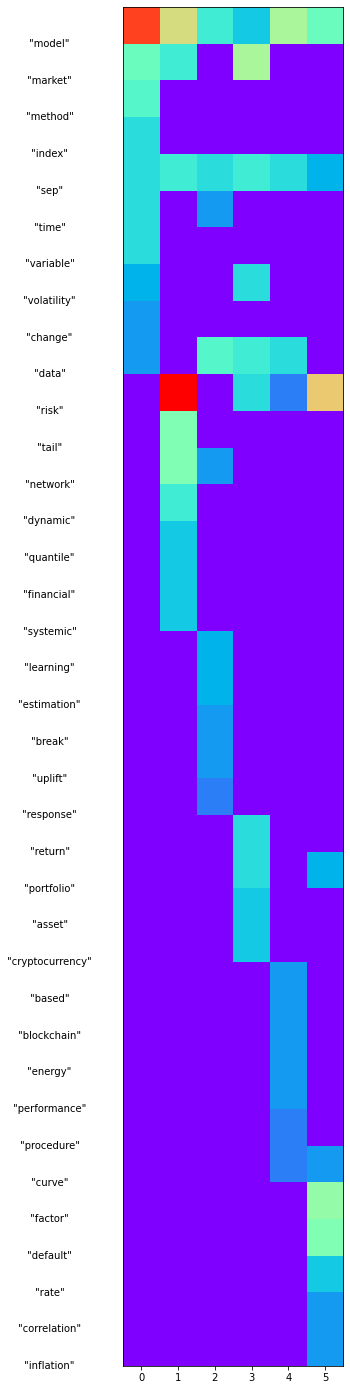

In [8]:
zz=np.resize(zz,(len(DC.keys()),zz.shape[1]))
plt.figure(figsize=(80,25))
for val, key in enumerate(DC.keys()):
        plt.text(-2.5, val + 0.5, key,
                 horizontalalignment='center',
                 verticalalignment='center'
                 )
#plt.imshow(zz, cmap='hot', interpolation='nearest')
plt.imshow(zz, cmap='rainbow', interpolation='nearest')
#plt.show()
plt.yticks([])
# plt.title("heatmap xmas song")
plt.savefig("heatmap_abstract.png", transparent = True, dpi=400)